## Importing necessary dependencies and libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import math

## Data loading and pre-processing

In [ ]:
# Loading the dataset
df = pd.read_csv("stock.csv")

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.iloc[:, 1:])

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,pct_change,log_change,SMA_07,...,BB_LOWER,BB_MIDDLE,BB_UPPER,RSV_14,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
0,2020-05-26,122.900002,123.099998,120.703003,121.093002,121.093002,71364000,-0.006164,-0.006183,122.062787,...,113.909932,119.476525,125.043119,48.131974,147.335972,140.683243,139.998095,136.093582,133.031545,133.392025
1,2020-05-27,120.249496,120.679001,116.500000,120.519501,120.519501,101138000,-0.004736,-0.004747,122.067144,...,114.413882,119.717300,125.020718,37.903358,147.471658,140.903212,140.117815,134.458143,127.761801,127.145829
2,2020-05-28,119.216499,121.848503,118.911499,120.055000,120.055000,63804000,-0.003854,-0.003862,121.887429,...,114.506719,119.788276,125.069832,31.314232,147.605922,141.126894,140.243517,132.884647,123.760151,122.381789
3,2020-05-29,120.796997,122.118500,119.910004,122.118500,122.118500,70198000,0.017188,0.017042,121.837715,...,114.620438,119.709201,124.797963,60.585806,147.738772,141.354208,140.375545,131.402958,121.323848,119.651524
4,2020-06-01,122.400002,123.846497,122.208504,123.552002,123.552002,58578000,0.011739,0.011670,121.645572,...,115.465774,120.171701,124.877627,80.920614,147.870217,141.585073,140.514229,130.041813,120.461870,119.059476


In [ ]:
scaled_data[1,:]

array([0.35871164, 0.35369004, 0.33913714, 0.36944456, 0.36944456,
       0.31468143, 0.49213944, 0.52686291, 0.37765942, 0.36637081,
       0.34927357, 0.24200072, 0.12752918, 0.73824236, 0.58869158,
       0.15202096, 0.38080187, 0.35077291, 0.32952558, 0.37903358,
       0.66840264, 0.63031523, 0.61475352, 0.50420803, 0.43858055,
       0.41894593])

In [ ]:
# Prepare data for LSTM
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 10  # Number of time steps to look back
X, y = prepare_data(scaled_data, time_steps)

In [ ]:
# Reshape data for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], scaled_data.shape[1])
y = y.reshape(y.shape[0], scaled_data.shape[1])

In [ ]:
# Split data into training and testing sets
split = int(0.8 * len(df))  # 80-20 split
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
X.shape

(877, 30, 26)

## LSTM

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dense(26))  # Output layer with 26 neurons (one for each feature)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
23/23 [==============================] - 5s 28ms/step - loss: 0.1656
Epoch 2/10
23/23 [==============================] - 1s 28ms/step - loss: 0.0229
Epoch 3/10
23/23 [==============================] - 1s 28ms/step - loss: 0.0143
Epoch 4/10
23/23 [==============================] - 1s 29ms/step - loss: 0.0120
Epoch 5/10
23/23 [==============================] - 1s 28ms/step - loss: 0.0107
Epoch 6/10
23/23 [==============================] - 1s 29ms/step - loss: 0.0096
Epoch 7/10
23/23 [==============================] - 1s 29ms/step - loss: 0.0084
Epoch 8/10
23/23 [==============================] - 1s 28ms/step - loss: 0.0075
Epoch 9/10
23/23 [==============================] - 1s 29ms/step - loss: 0.0071
Epoch 10/10
23/23 [==============================] - 1s 29ms/step - loss: 0.0065


In [ ]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)



5/5 [==============================] - 0s 9ms/step


In [ ]:
# Inverse transform the predictions to get the original scale
train_predictions_inv = scaler.inverse_transform(train_predictions)
test_predictions_inv = scaler.inverse_transform(test_predictions)
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)


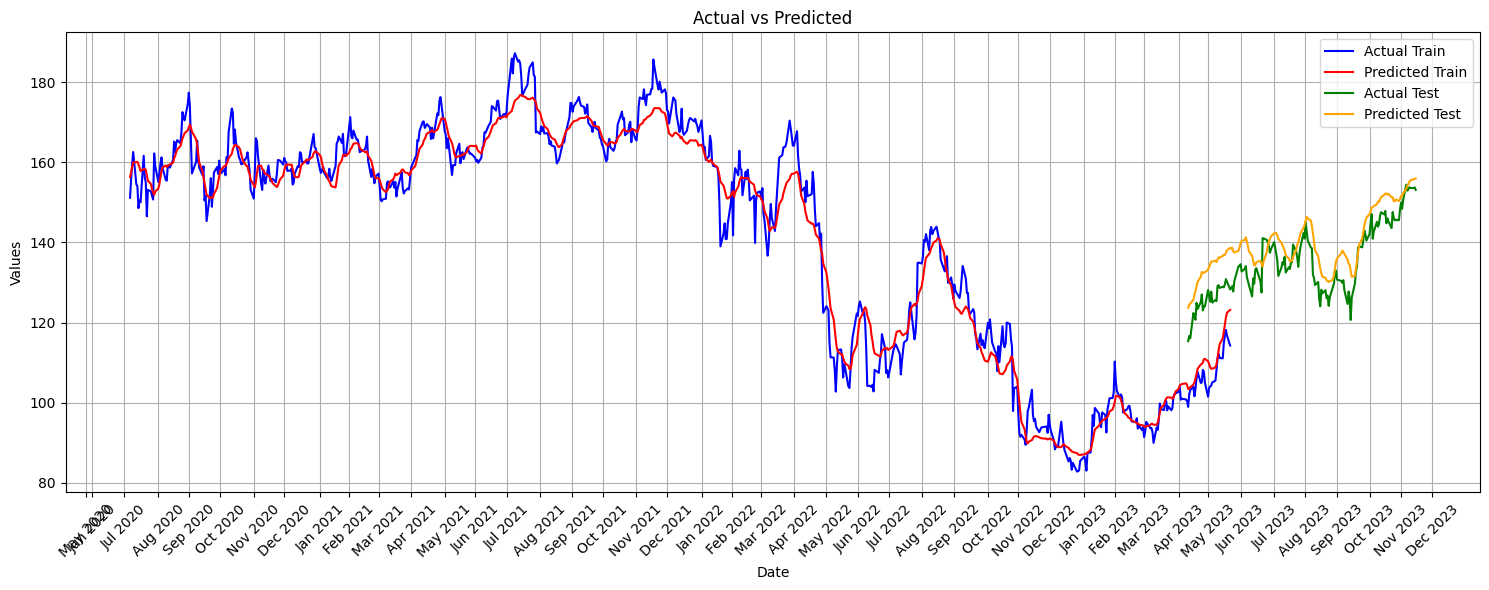

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

# Extract month from the 'Date' column
df['Month'] = df['Date'].dt.month

# Find the indices where the month changes
month_changes = np.where(df['Month'].diff() != 0)[0]

plt.figure(figsize=(15, 6))

# Plot actual and predicted values for training data
plt.plot(df['Date'][(time_steps - 1):(time_steps - 1 + len(y_train_inv))], y_train_inv[:, 0], label='Actual Train', color='blue')
plt.plot(df['Date'][(time_steps - 1):(time_steps - 1 + len(train_predictions_inv))], train_predictions_inv[:, 0], label='Predicted Train', color='red')

# Plot actual and predicted values for testing data
plt.plot(df['Date'][split:(split + len(y_test_inv))], y_test_inv[:, 0], label='Actual Test', color='green')
plt.plot(df['Date'][split:(split + len(test_predictions_inv))], test_predictions_inv[:, 0], label='Predicted Test', color='orange')

# Set x-axis ticks to only include changing months
plt.xticks(df['Date'][month_changes], df['Date'].dt.strftime('%b %Y')[month_changes], rotation=45)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Performance Metric

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# Calculate MSE and RMSE for training data
train_mse = mean_squared_error(y_train_inv[:, 0], train_predictions_inv[:, 0])
train_rmse = math.sqrt(train_mse)

# Calculate MSE and RMSE for testing data
test_mse = mean_squared_error(y_test_inv[:, 0], test_predictions_inv[:, 0])
test_rmse = math.sqrt(test_mse)

print("Training MSE:", train_mse)
print("Training RMSE:", train_rmse)
print("Testing MSE:", test_mse)
print("Testing RMSE:", test_rmse)


Training MSE: 22.904932301740708
Training RMSE: 4.785909767404804
Testing MSE: 35.179266548311524
Testing RMSE: 5.931211221016456
